## Importing Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA, TruncatedSVD

In [119]:
# Carregar os dados
movies_df = pd.read_csv('./Data/movies.dat', encoding='latin1', sep='::', names=['movieId', 'movie', 'genres'])
ratings_df = pd.read_csv('./Data/ratings.dat', encoding='latin1', sep='::', names=['userId','movieId', 'rating', 'timestamp'])


C:\Users\lucas\AppData\Local\Temp\ipykernel_47728\2317302246.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies_df = pd.read_csv('./Data/movies.dat', encoding='latin1', sep='::', names=['movieId', 'movie', 'genres'])
C:\Users\lucas\AppData\Local\Temp\ipykernel_47728\2317302246.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings_df = pd.read_csv('./Data/ratings.dat', encoding='latin1', sep='::', names=['userId','movieId', 'rating', 'timestamp'])


In [21]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [22]:
movies_df.head()

,movieId,movie,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


## Exploratory Analysis

### Basic Information about dataset

In [33]:

num_movies = movies_df['movieId'].nunique()
num_genres = movies_df['genres'].nunique()
num_users = ratings_df['userId'].nunique()
num_movies_ratings = ratings_df['movieId'].nunique()
print(f"Number of movies in movie df: {num_movies}")
print(f"Number of movies in ratings df: {num_movies_ratings}")

print(f"Number of genres: {num_genres}")
print(f"Number of users: {num_users}")
print(f'Number of ratings:', ratings_df.shape[0])

Number of movies in movie df: 3883
Number of movies in ratings df: 3706
Number of genres: 301
Number of users: 6040
Number of ratings: 1000209


- If each user had rated each movie we would have 6040*3883 = 23453320, ratings. This is not the case.
- Some films were not evaluated since the number of unique films in the film dataframe is higher than in the rating dataframe

### Distribution charts over the years

#### Number of filmes over years
<hr/>

<>:1: SyntaxWarning: invalid escape sequence '\('
<>:1: SyntaxWarning: invalid escape sequence '\('
C:\Users\lucas\AppData\Local\Temp\ipykernel_47728\1380771106.py:1: SyntaxWarning: invalid escape sequence '\('
  movies_df['year'] = movies_df['movie'].str.extract('\((\d{4})\)', expand=False)


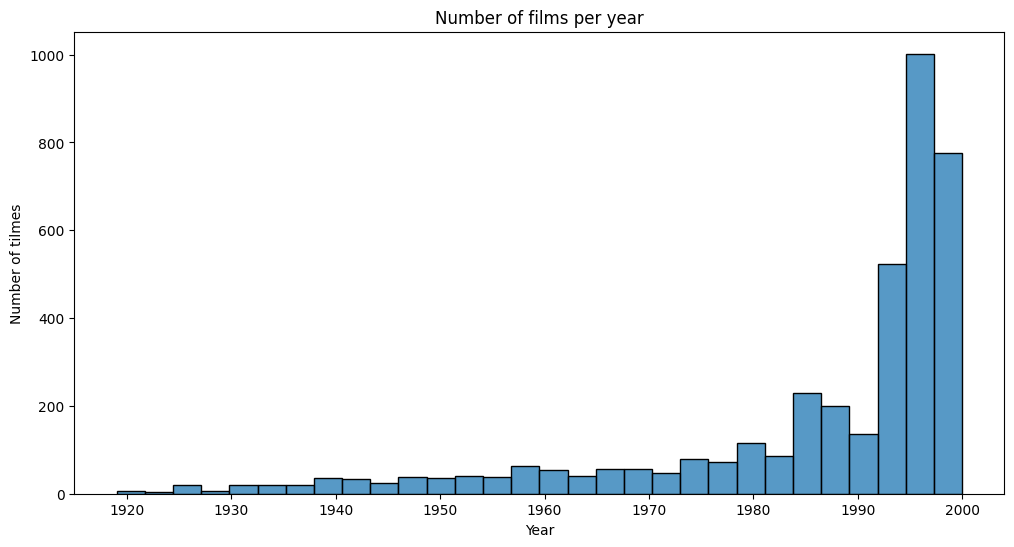

In [120]:
movies_df['year'] = movies_df['movie'].str.extract('\((\d{4})\)', expand=False)
movies_df['year'] = pd.to_numeric(movies_df['year'], errors='coerce')
plt.figure(figsize=(12, 6))
sns.histplot(data=movies_df.dropna(), x='year', bins=30)
plt.title('Number of films per year')
plt.xlabel('Year')
plt.ylabel('Number of tilmes')
plt.show()


- the films are mostly from the 90s to the 2000s

#### Distribution of genres over years
<hr/>

In [203]:
bins = range(movies_df['year'].min(), movies_df['year'].max() + 10, 9)
# Adicionar coluna de década
movies_df['decade'] = pd.cut(movies_df['year'], bins=bins, right=False, labels=bins[:-1]).astype(int)
last_year = movies_df.groupby('decade')['year'].max().to_dict()
fisrt_year = movies_df.groupby('decade')['year'].min().to_dict()

movies_df['decade'] = movies_df['decade'].map(lambda x: f'{fisrt_year[x]}-{last_year[x]}')


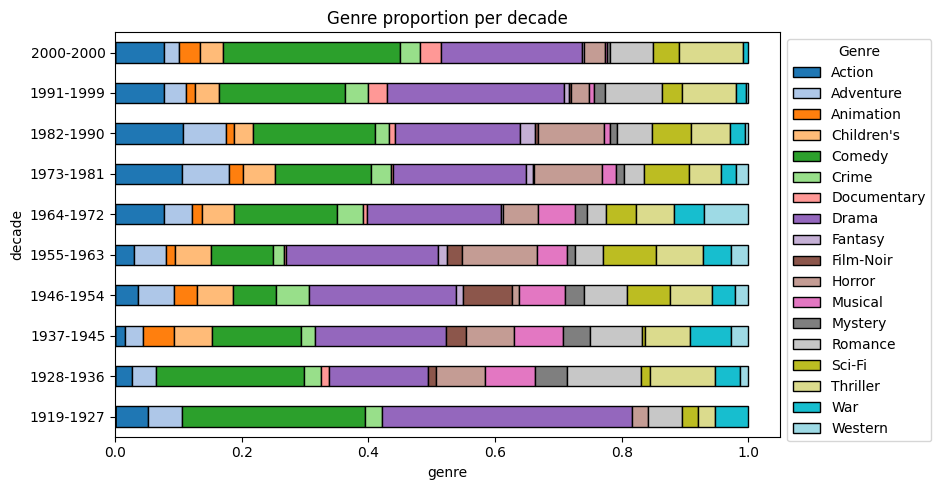

In [204]:
# Calcular a proporção de cada gênero por década
genres = movies_df['genres'].str.get_dummies('|')
genre_df = pd.concat([movies_df, genres], axis=1)

# Agrupar por década e calcular a proporção de cada gênero
genres_by_decade = genre_df.groupby('decade')[genres.columns].sum()
genres_prop = genres_by_decade.div(genres_by_decade.sum(axis=1), axis=0)

# Plotar heatmap de proporção de gêneros por década

genres_prop.plot(kind='barh', stacked=True, colormap='tab20', edgecolor='black', figsize=(8, 5))
plt.title('Genre proportion per decade')
plt.xlabel('genre')
plt.tight_layout()
plt.ylabel('decade')
plt.legend(title='Genre', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

- Some genres seem to keep it popularity, such as drama
- Some has lost its popularity over the years, such as war movies
- Comedy, on the other hand, started out famous, went downhill and came back to fame more recently
- Comedy and drama lead the proportion in almost every year

#### Distribution of reviews
<hr/>

In [221]:
ratings_dist = ratings_df.merge(movies_df, on='movieId')

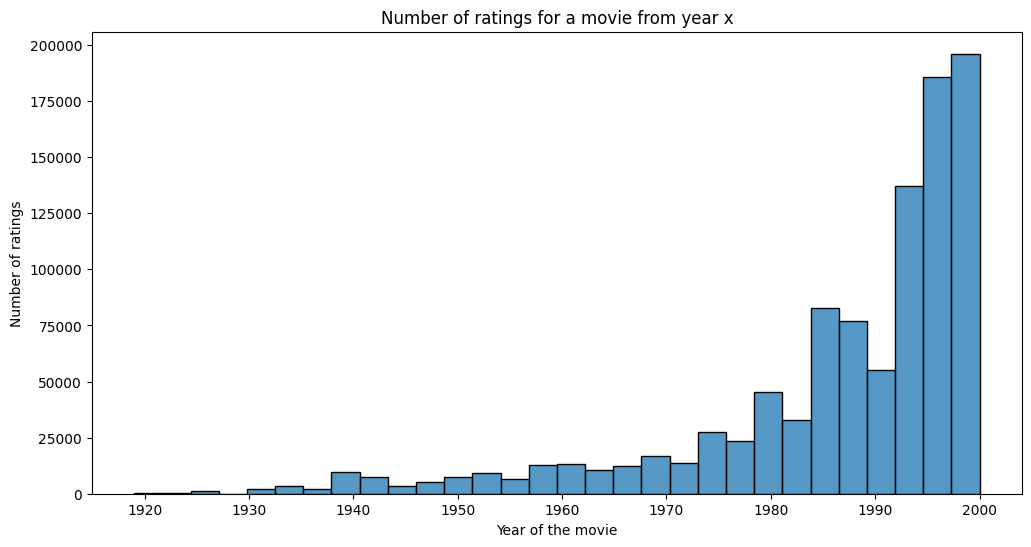

In [222]:

plt.figure(figsize=(12, 6))
sns.histplot(data=ratings_dist, x='year', bins=30)
plt.title('Number of ratings for a movie from year x')
plt.xlabel('Year of the movie')
plt.ylabel('Number of ratings')
plt.show()


- the ratings are also mostly from the 90s to the 2000s

## Pre-Processing

### Check for duplicate values

In [224]:
movies_df.shape, movies_df.drop_duplicates().shape

((3883, 5), (3883, 5))

In [231]:
ratings_df.shape, ratings_df.drop_duplicates().shape

((1000209, 4), (1000209, 4))

- No duplicated movies or duplicated ratings

### Generate movie x ratings matrix
- fill values with 0 when movie was not evaluated by an user

In [237]:
movie_ratings_df = movies_df.merge(ratings_df, on='movieId')

movie_ratings_matrix = pd.pivot_table(movie_ratings_df, values='rating', index='movieId', columns='userId', fill_value=0)
movie_ratings_matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
movieId,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,5.0,5.0,...,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [281]:
movie_ratings_matrix

userId,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
movieId,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,5.0,5.0,...,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Remove outlies

In [272]:
usuarios_constantes = movie_ratings_matrix.columns[movie_ratings_matrix.nunique() == 2]


In [273]:
usuarios_constantes.shape

(0,)

- There are no users who have given the same rating to all the films

In [314]:
# Calculando a contagem de cada nota por usuário
ratings_counts = movie_ratings_matrix.apply(lambda row: row[row != 0].value_counts().sort_values(ascending=False).iloc[0], axis=0)
num_avaliacoes_por_usuario = movie_ratings_matrix[movie_ratings_matrix != 0].count()

# Calculando a porcentagem de notas iguais para cada usuário
percent_same_rating = (ratings_counts / num_avaliacoes_por_usuario) * 100

In [329]:
movie_ratings_matrix.loc[:, percent_same_rating > 90].iloc[:, 1].value_counts()

907
0.0    3685
4.0      19
2.0       1
5.0       1
Name: count, dtype: int64

In [339]:
movie_ratings_filtered = movie_ratings_matrix.loc[:, ~(percent_same_rating > 90)]

- Some users give practically (90% of the time) the same score for all movies, let's remove it from the dataset

In [340]:
usuarios_sem_avaliacao = movie_ratings_filtered.columns[movie_ratings_filtered.eq(0).all()]

In [341]:
usuarios_sem_avaliacao

Index([], dtype='int64', name='userId')

- all users have rated at least one movie

### Normalize matrix
- Using Stardard Scaler

In [342]:

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the ratings matrix
normalized_ratings = scaler.fit_transform(movie_ratings_matrix)

# Convert the normalized array back to DataFrame
normalized_df = pd.DataFrame(normalized_ratings, index=movie_ratings_matrix.index, columns=movie_ratings_matrix.columns)


normalized_df.head()

userId,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
movieId,,,,,,,,,,,,,,,,,,,,,
1,9.805331,-0.183178,-0.114552,-0.073206,-0.222881,7.177825,-0.090532,5.075311,7.671591,3.483641,...,-0.110018,5.517974,-0.124926,-0.073641,4.724672,-0.528970,-0.233352,-0.070855,-0.181994,2.441071
2,-0.118898,-0.183178,-0.114552,-0.073206,-0.222881,-0.136678,-0.090532,-0.191870,-0.167528,3.483641,...,-0.110018,-0.164842,-0.124926,-0.073641,-0.245067,-0.528970,-0.233352,-0.070855,-0.181994,-0.300880
3,-0.118898,-0.183178,-0.114552,-0.073206,-0.222881,-0.136678,-0.090532,-0.191870,-0.167528,-0.340522,...,-0.110018,-0.164842,-0.124926,-0.073641,0.997367,-0.528970,-0.233352,-0.070855,-0.181994,-0.300880
4,-0.118898,-0.183178,-0.114552,-0.073206,-0.222881,-0.136678,-0.090532,3.758516,-0.167528,-0.340522,...,-0.110018,-0.164842,-0.124926,-0.073641,2.239802,0.807793,-0.233352,-0.070855,-0.181994,-0.300880
5,-0.118898,-0.183178,-0.114552,-0.073206,-0.222881,-0.136678,-0.090532,-0.191870,-0.167528,-0.340522,...,-0.110018,-0.164842,-0.124926,-0.073641,0.997367,-0.528970,-0.233352,-0.070855,-0.181994,-0.300880


### Calculate distance matrix

In [343]:
from sklearn.metrics import pairwise_distances
matriz_distancias_cosine = pairwise_distances(normalized_df.values, metric='cosine', n_jobs=-1)

In [344]:
# Converter a matriz de distâncias para um DataFrame do Pandas
df_distancias_cosine = pd.DataFrame(matriz_distancias_cosine, index=normalized_df.index, columns=normalized_df.index)


## Clustering without dimensionality reducion

### DBSCAN

In [393]:
dbscan = DBSCAN(eps=0.01, min_samples=10, metric='precomputed')
clusters = dbscan.fit_predict(df_distancias_cosine)
pd.Series(clusters).value_counts()


-1    3634
 0      72
Name: count, dtype: int64

- trying eps 0.01 -  too many outliers

In [398]:
dbscan = DBSCAN(eps=0.5, min_samples=10, metric='precomputed')
clusters = dbscan.fit_predict(df_distancias_cosine)
pd.Series(clusters).value_counts()


-1    2428
 0    1278
Name: count, dtype: int64

- trying 0.5 - half of the dataset still outlier

In [404]:
dbscan = DBSCAN(eps=0.6, min_samples=10, metric='precomputed')
clusters = dbscan.fit_predict(df_distancias_cosine)
pd.Series(clusters).value_counts()


-1    2009
 0    1594
 1      91
 2      12
Name: count, dtype: int64

- trying 0.6 - a bit better

In [ ]:
dbscan = DBSCAN(eps=0.6, min_samples=10, metric='precomputed')
clusters = dbscan.fit_predict(df_distancias_cosine)
pd.Series(clusters).value_counts()


### Hieralchical Clustering

### Kmeans

## Clustering with dimensionality reducion

### PCA